<a href="https://colab.research.google.com/github/keunsooyoon/Algorithms/blob/main/Emergence_in_SAT_Problems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.9 MB/s eta 0:00:00
  Created wheel for pypblib: filename=pypblib-0.0.4-cp311-cp311-linux_x86_64.whl size=2973733 sha256=f88a6a5b15028a6d517a9b28ebf4a1d9c5c54b875a01f93f4c07a28398036128
  Stored in directory: /root/.cache/pip/wheels/55/c5/26/eb71ff12b35b705794daf31cbd226a9aac7a40866ad4df7e73
Successfully built pypblib


Running for n=60: 100%|██████████| 21/21 [00:03<00:00,  6.43it/s]


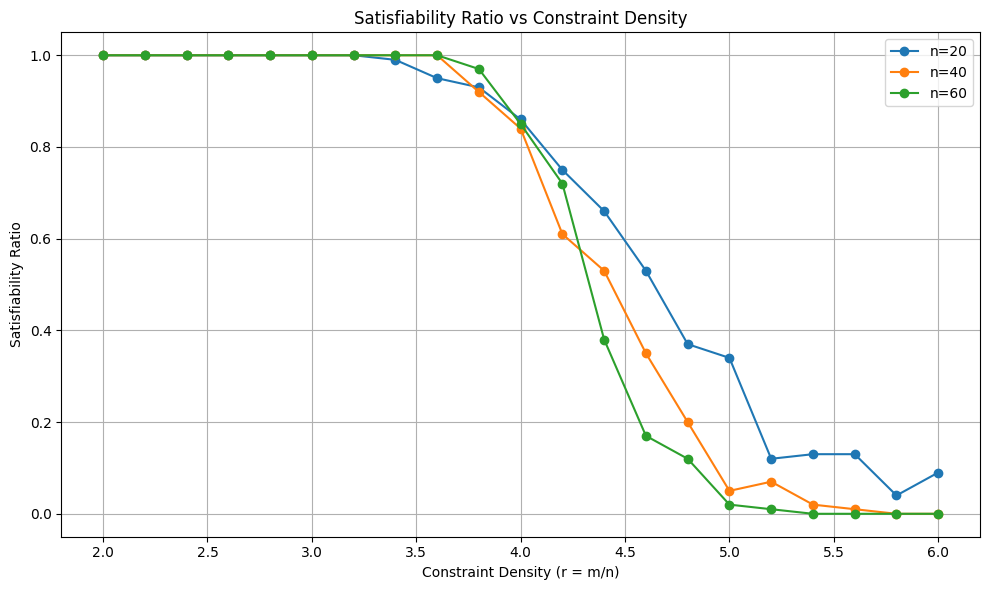

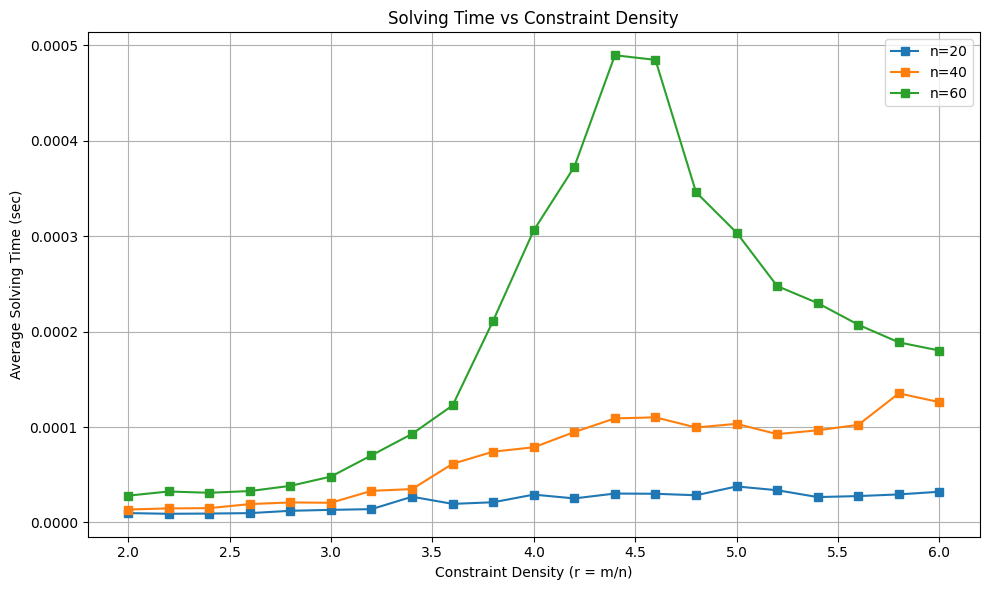

In [ ]:
# Install PySAT (only needed on Google Colab)
!pip install python-sat[pblib,aiger]

# Import required libraries
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from pysat.solvers import Glucose3
from tqdm import tqdm  # For progress bar

# Experiment configuration
n_values = [20, 40, 60]                  # Number of variables
r_values = np.arange(2.0, 6.1, 0.2)      # Constraint density (m/n)
instances_per_setting = 100             # Number of SAT instances per setting

# Dictionary to store experiment results
results = {}

# Function: Generate a random 3-SAT instance
def generate_3sat_instance(n, m):
    """
    Generates a random 3-SAT CNF instance with n variables and m clauses.
    Each clause contains 3 literals, with 50% chance of negation.
    """
    clauses = []
    for _ in range(m):
        vars = random.sample(range(1, n + 1), 3)  # Choose 3 distinct variables
        clause = []
        for v in vars:
            clause.append(-v if random.random() < 0.5 else v)
        clauses.append(clause)
    return clauses

# Run experiment for each combination of (n, r)
for n in n_values:
    sat_ratios = []   # Satisfiability ratio per r
    avg_times = []    # Average solving time per r

    for r in tqdm(r_values, desc=f"Running for n={n}"):
        m = int(r * n)       # Number of clauses
        sat_count = 0        # Number of satisfiable instances
        total_time = 0.0     # Total solving time

        for _ in range(instances_per_setting):
            cnf = generate_3sat_instance(n, m)  # Generate CNF
            solver = Glucose3()                 # Initialize SAT solver

            for clause in cnf:
                solver.add_clause(clause)

            start = time.time()
            sat = solver.solve()
            elapsed = time.time() - start

            if sat:
                sat_count += 1
            total_time += elapsed

            solver.delete()

        # Compute statistics for this (n, r) setting
        sat_ratio = sat_count / instances_per_setting
        avg_time = total_time / instances_per_setting
        sat_ratios.append(sat_ratio)
        avg_times.append(avg_time)

    # Save results for this n
    results[n] = {
        'r': list(r_values),
        'sat_ratio': sat_ratios,
        'avg_time': avg_times
    }

# Plot 1: Satisfiability Ratio vs Constraint Density
plt.figure(figsize=(10, 6))
for n in n_values:
    plt.plot(results[n]['r'], results[n]['sat_ratio'],
             label=f'n={n}', marker='o')
plt.xlabel("Constraint Density (r = m/n)")
plt.ylabel("Satisfiability Ratio")
plt.title("Satisfiability Ratio vs Constraint Density")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("satisfiability_ratio.png")
plt.show()

# Plot 2: Average Solving Time vs Constraint Density
plt.figure(figsize=(10, 6))
for n in n_values:
    plt.plot(results[n]['r'], results[n]['avg_time'],
             label=f'n={n}', marker='s')
plt.xlabel("Constraint Density (r = m/n)")
plt.ylabel("Average Solving Time (sec)")
plt.title("Solving Time vs Constraint Density")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("solving_time.png")
plt.show()
